In [6]:
import pandas as pd
import geopandas as gp
import numpy as np
import rasterio as rio
import xarray
import rioxarray
import matplotlib.pyplot as plt

In [7]:
xds = xarray.open_dataset("data/FF_201212_CF.nc")

In [8]:
xds_filtered = xds.where(xds.time == np.unique(xds.time)[0], drop = True)

(3850000.0, 3950000.0, 2350000.0, 2550000.0)

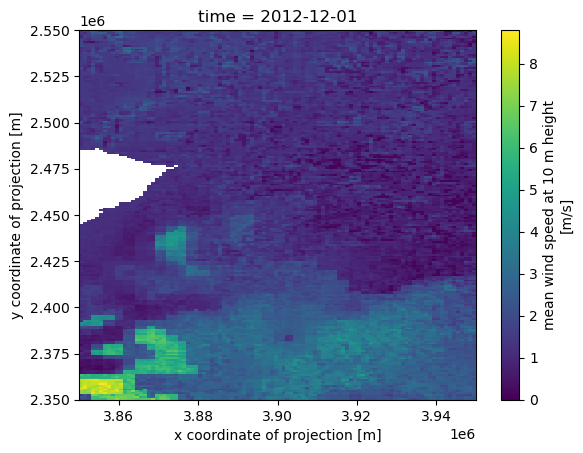

In [291]:
xds_filtered.FF.plot()
#plt.axis([x * 1e6 for x in [3.8, 4.0, 2.3, 2.6]])
plt.axis([x * 1e6 for x in [3.85, 3.95, 2.35, 2.55]])

In [110]:
import pyrosm as psm
import geopandas as gpd
import shapely

In [21]:
# Initialize the OSM parser object with test data from Helsinki
osm = psm.OSM("data/tuebingen-regbez-latest.osm.pbf")

In [102]:
# Filter for power lines
# https://pyrosm.readthedocs.io/en/latest/custom_filter.html
# https://wiki.openstreetmap.org/wiki/Map_features#Power
power = ["line"] #, "minor_line", "cable"
grid = osm.get_data_by_custom_criteria(custom_filter={"power": power},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)

In [103]:
states = gpd.read_file("data/gadm41_DEU_shp/gadm41_DEU_1.shp")

(9.0, 9.5, 47.75, 48.0)

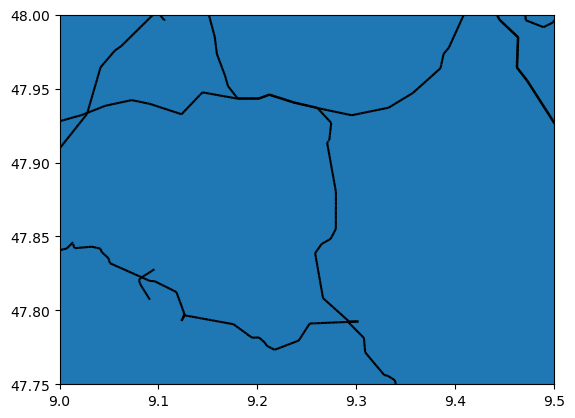

In [258]:
fig, ax = plt.subplots(1, 1)
states.plot(ax = ax)
grid.plot(ax = ax, color = "black")
#plt.axis([8.5, 10.5, 47, 49])
plt.axis([9.0, 9.5, 47.75, 48])

In [127]:
grid = grid.explode("geometry").reset_index()

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_25209/805880078.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  grid = grid.explode("geometry").reset_index()


In [ ]:
import networkx as nx
import momepy

In [ ]:
# https://networkx.org/documentation/latest/auto_examples/geospatial/fix_plot_lines.html#sphx-glr-auto-examples-geospatial-fix-plot-lines-py
geo_graph = momepy.gdf_to_nx(grid, approach = "dual")

/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:98: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = gdf_network.geometry.centroid


(47.9, 48.0)

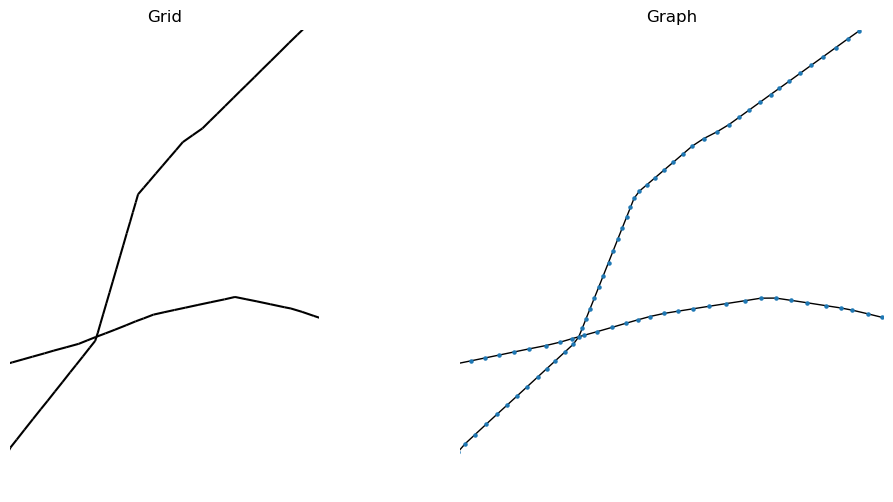

In [ ]:
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}

# Plot
f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
grid.plot(color="k", ax=ax[0])
for i, facet in enumerate(ax):
    facet.set_title(("Grid", "Graph")[i])
    facet.axis("off")
nx.draw(geo_graph, positions, ax=ax[1], node_size=5)
ax[0].set_xlim([9.0, 9.1])
ax[0].set_ylim([47.9, 48])

In [ ]:
centrality = nx.closeness_centrality(geo_graph)

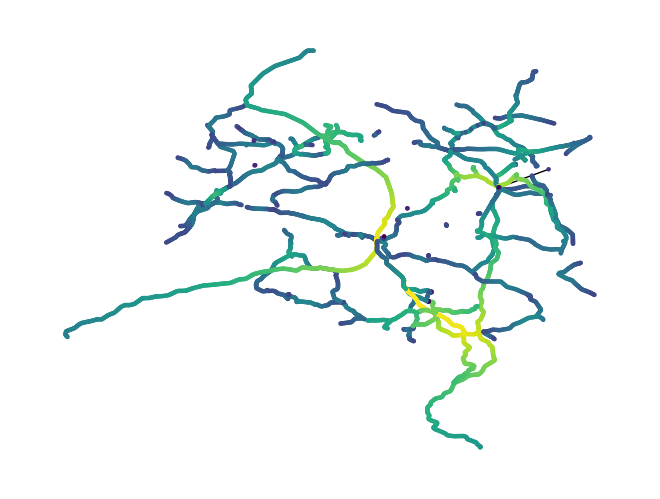

In [ ]:
nx.draw(geo_graph, positions, node_color = list(centrality.values()), node_size=5)

In [181]:
from tqdm import tqdm

out = [None] * len(grid)
for i in tqdm(range(len(grid))):
    f.value += 1
    tmp = [grid.loc[i, "geometry"].intersects(x) for x in grid.loc[:, "geometry"]]
    out[i] = [i for i, x in enumerate(tmp) if x]

In [189]:
import json
with open("data/grid_intersects.json", "w") as file:
    file.write(json.dumps(out))

In [195]:
for i in range(len(out)):
    out[i].remove(i)

<AxesSubplot: >

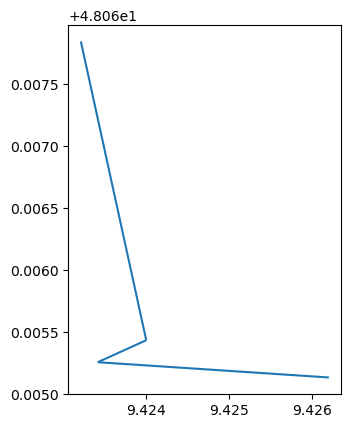

In [237]:
subgrid = grid.loc[out[0],:]
subgrid.plot()

/usr/local/anaconda3/envs/geospatial/lib/python3.10/site-packages/momepy/utils.py:247: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


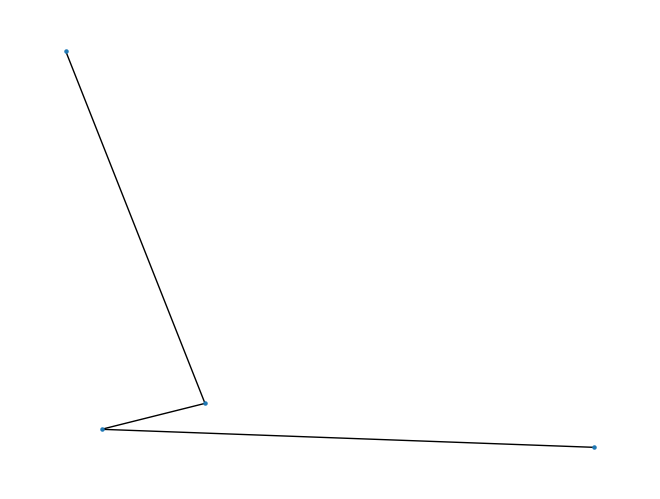

In [229]:
geo_graph = momepy.gdf_to_nx(subgrid)
positions = {n: [n[0], n[1]] for n in list(geo_graph.nodes)}
nx.draw(geo_graph, positions, node_size=5)

In [257]:
shapely.ops.split(subgrid["geometry"].iloc[1], subgrid["geometry"].iloc[0]).geoms[1]


IndexError: index out of range

{'whiskers': [<matplotlib.lines.Line2D at 0x3d813dcf0>,
 'caps': [<matplotlib.lines.Line2D at 0x3d813e230>,
 'boxes': [<matplotlib.lines.Line2D at 0x3d813da50>],
 'medians': [<matplotlib.lines.Line2D at 0x3d813e770>],
 'fliers': [<matplotlib.lines.Line2D at 0x3d813ea10>],
 'means': []}

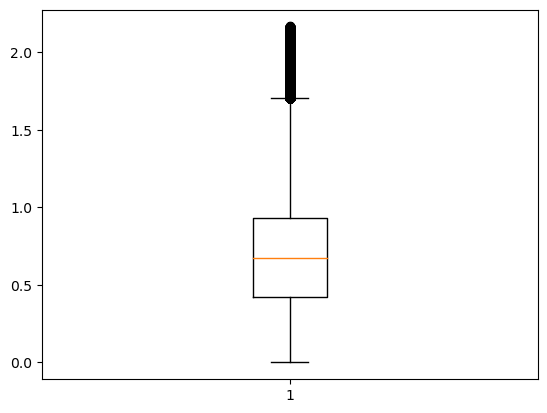

In [289]:
import scipy.spatial.distance
plt.boxplot(scipy.spatial.distance.pdist(geo_graph.nodes, "euclidean"))

In [151]:
for i in range(len(grid["geometry"][0:1])):
    shapely.ops.split(grid.loc[i, "geometry"], 
                      grid.loc[np.bitwise_not(grid.index==i), "geometry"])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
"started": "2022-10-18T13:08:01.977096Z", "pending": null, "ready": true, "url": "/jhub/user/tu_zxobe27/", "user_options": {"nprocs": ["1"], "gpu": ["0"], "runtime": ["0:30:00"], "partition": ["single"], "memory": ["4G"], "basemoduleselect": ["jupyter/tensorflow"], "basemodule": ["jupyter/tensorflow"], "autoreservationstring": ["true"], "expertmodestring": ["false"], "reservation": [""], "reservationstring": ["#SBATCH --reservation=juypter_weekday_cpuonly"], "groupname": [""], "groupnamestring": [""], "lsdfstring": [""], "beeondstring": [""], "containermodestring": ["false"], "containermodedeactivate": [""], "containermodeactivate": ["#"], "containerimage": [""], "containerimagestring": [""], "containername": [""], "containernameifvoid": ["1666084949323"], "containernamestring": [""], "enrootmounthomestring": [""], "enrootdefaultmountstring": [""], "enrootremaprootstring": [""]}, "progress_url": "/jhub/hub/api/users/tu_zxobe27/server/progress"}}}

In [50]:
import requests

user = "tu_zxobe27"
token = 

b'{"name": "tu_zxobe27", "created": "2022-06-28T18:42:40.993052Z", "server": "/jhub/user/tu_zxobe27/", "groups": [], "last_activity": "2022-10-18T13:08:26.100618Z", "kind": "user", "admin": false, "pending": null, "roles": ["user"], "servers": {"": {"name": "", "last_activity": "2022-10-18T13:08:26.100618Z", "started": "2022-10-18T13:08:01.977096Z", "pending": null, "ready": true, "url": "/jhub/user/tu_zxobe27/", "user_options": {"nprocs": ["1"], "gpu": ["0"], "runtime": ["0:30:00"], "partition": ["single"], "memory": ["4G"], "basemoduleselect": ["jupyter/tensorflow"], "basemodule": ["jupyter/tensorflow"], "autoreservationstring": ["true"], "expertmodestring": ["false"], "reservation": [""], "reservationstring": ["#SBATCH --reservation=juypter_weekday_cpuonly"], "groupname": [""], "groupnamestring": [""], "lsdfstring": [""], "beeondstring": [""], "containermodestring": ["false"], "containermodedeactivate": [""], "containermodeactivate": ["#"], "containerimage": [""], "containerimagestr

In [2]:
import modules.jupyter_environment
env = modules.jupyter_environment.jupyter_environment("tu_zxobe27", "c6bb5fc4375b4b41a4c87e7310b4b17c")

In [8]:
env.get_status()

{'name': 'tu_zxobe27',
 'created': '2022-06-28T18:42:40.993052Z',
 'server': '/jhub/user/tu_zxobe27/',
 'groups': [],
 'last_activity': '2022-10-18T15:35:08.114620Z',
 'kind': 'user',
 'admin': False,
 'pending': None,
 'roles': ['user'],
 'servers': {'': {'name': '',
   'last_activity': '2022-10-18T15:35:08.114620Z',
   'started': '2022-10-18T15:33:59.077352Z',
   'pending': None,
   'ready': True,
   'url': '/jhub/user/tu_zxobe27/',
   'user_options': {'nprocs': ['1'],
    'gpu': ['0'],
    'runtime': ['0:30:00'],
    'partition': ['single'],
    'memory': ['4G'],
    'basemoduleselect': ['jupyter/tensorflow'],
    'basemodule': ['jupyter/tensorflow'],
    'autoreservationstring': ['true'],
    'expertmodestring': ['false'],
    'reservation': [''],
    'reservationstring': ['#SBATCH --reservation=juypter_weekday_cpuonly'],
    'groupname': [''],
    'groupnamestring': [''],
    'lsdfstring': [''],
    'beeondstring': [''],
    'containermodestring': ['false'],
    'containermodedeac

In [5]:
env.start_server()

True

In [3]:
env.stop_server()

True

In [4]:
from owslib.wms import WebMapService

In [5]:
wms = WebMapService('https://isk.geobasis-bb.de/mapproxy/dop20_2016_2018/service/wms?', version='1.1.1')

In [12]:
wms.identification.title
wms.identification.abstract

'Dieser Web Map Service stellt digitale farbige und graue Orthophotos (Luftbilder) mit der Bodenauflösung von 20cm vom Gebiet Brandenburg (2016-2018)/Berlin (2017) zur Verfügung.'

In [13]:
list(wms.contents)

['dop20_bebb_2016_2018_farbe', 'dop20_bebb_2016_2018_graustufen']

In [16]:
wms["dop20_bebb_2016_2018_farbe"].crsOptions

['EPSG:3857',
 'EPSG:3034',
 'EPSG:25832',
 'EPSG:4326',
 'EPSG:25833',
 'EPSG:3035',
 'EPSG:4839',
 'CRS:84',
 'EPSG:5650',
 'EPSG:4258',
 'EPSG:900913',
 'EPSG:3045']

In [17]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [18]:
wms.getOperationByName('GetMap').formatOptions

['image/jpeg', 'image/png', 'image/gif']

In [2]:
bbox = (394168.38, 5796138.69, 394388.69, 5796390.61)

In [1]:
from modules.data.data_imagery import data_imagery

In [2]:
imagery_downloader = data_imagery("brandenburg")

['WMS BB-BE DOP20 2016-2018', 'Dieser Web Map Service stellt digitale farbige und graue Orthophotos (Luftbilder) mit der Bodenauflösung von 20cm vom Gebiet Brandenburg (2016-2018)/Berlin (2017) zur Verfügung.']


In [3]:
imagery_downloader.push_query((394168.38, 5796138.69, 394388.69, 5796390.61), crs = 25833)

In [4]:
imagery_downloader.run_query()

In [5]:
imagery_downloader.export_query()

[b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x04\xeb\x04M\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x1

In [8]:
import xarray
import rioxarray

In [11]:
test = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/brandenburg_394168.38_5796138.69_394388.69_5796390.61.nc")

In [24]:
test.shape

(3, 1259, 1101)

In [35]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [32]:
img_jpg = img.read()

In [39]:
with open("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.jpg", "wb") as file:
    file.write(img_jpg)

In [40]:
jpg = mpimg.imread("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/imagery/test.jpg")

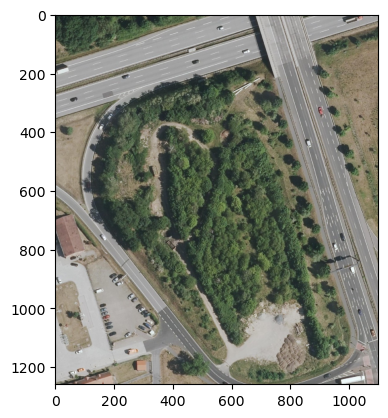

In [41]:
plt.imshow(jpg)